In [1]:
%matplotlib inline
import os
import numpy as np
import scipy.io as sio
import scipy as sp
import pickle 
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

In [2]:
data = pd.read_pickle('feats.pkl')
#data = pd.read_pickle('mat_feats.pkl')
X = data.drop(columns=['labels']).to_numpy()
labels = data['labels'].to_numpy()

## Se parte la matriz de características en entrenamiento y test

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X,labels,test_size = 0.3, random_state=50) 

## Se normalizan las características

In [4]:
#estandarización de la matriz de entrenamiento
mXtrain = np.mean(X_train,axis= 0)
sXtrain = np.std(X_train,axis= 0)    
X_train_norm = (X_train-mXtrain)/sXtrain

#estandarización de la matriz de test
X_test_norm = (X_test-mXtrain)/sXtrain

## Se entrega el modelo y se transformanlos datos para diferentes configuraciones de q

In [5]:
from sklearn.decomposition import PCA
Q = np.arange(1, X_train_norm.shape[1], 2)
Q=np.append(Q,213)

pca_train = []
pca_test = []

for q in Q: 
  pca = PCA(n_components=q)
  X_train_pca = pca.fit_transform(X_train_norm)
  X_test_pca = pca.transform(X_test_norm)
  pca_train.append(X_train_pca)
  pca_test.append(X_test_pca)

#pca_train.append(X_train_norm)
#pca_test.append(X_test_norm)


## Se entrena el clasificador bayesiano

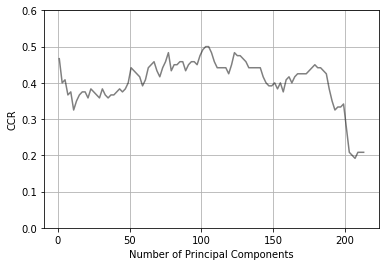

In [6]:
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.metrics import accuracy_score

Acc=[]
for i in range(len(pca_train)): 
  # Se crea el modelo (ej. clasificador)
  clf = GaussianNB()
  # Se entrena el modelo
  clf.fit(pca_train[i],y_train)
  # Se realiza una predicción
  Acc.append(accuracy_score(y_test,clf.predict(pca_test[i])))

plt.figure()
plt.plot(Q,Acc,color='k',alpha=0.5)
plt.xlabel("Number of Principal Components")
plt.ylabel("CCR")
plt.ylim([0,0.6])
plt.grid()
plt.show()

Se calcula la tasa de acierto para la matriz de test de entrada normalizada

In [7]:
print('Accuracy: ', accuracy_score(y_test,clf.predict(X_test_norm)))

Accuracy:  0.11666666666666667


## Se entrena el regresor logístico

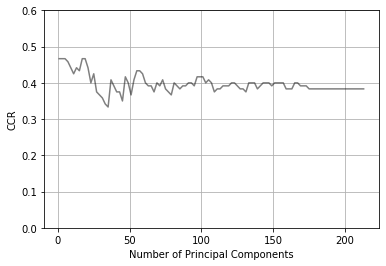

In [8]:
from sklearn.linear_model import LogisticRegression

Acc=[]
for i in range(len(pca_train)): 
  # Se crea el modelo (ej. clasificador)
  model = LogisticRegression(solver='newton-cg')
  # Se entrena el modelo
  model.fit(pca_train[i],y_train)
  # Se realiza una predicción
  Acc.append(accuracy_score(y_test,model.predict(pca_test[i])))

plt.figure()
plt.plot(Q,Acc,color='k',alpha=0.5)
plt.xlabel("Number of Principal Components")
plt.ylabel("CCR")
plt.ylim([0,0.6])
plt.grid()
plt.show()


Se calcula la tasa de acierto para la matriz de test de entrada normalizada

In [9]:
print('Accuracy: ', accuracy_score(y_test,model.predict(X_test_norm)))

Accuracy:  0.2


## Segundo punto

Validación cruzada

In [10]:
from sklearn.model_selection import GridSearchCV,StratifiedKFold

def folds_dist(spkID,y,k_splits=10):
   """
   Fold distribution
   """
   #Validacion cruzada de k-particiones
   kf = StratifiedKFold(n_splits=k_splits, random_state=None, shuffle=False)
   idxtrain = []
   idxtest = []
   for x,y in kf.split(spkID,y):
       idxtrain.append(x)
       idxtest.append(y)
   return idxtrain,idxtest

In [43]:
def train(X_train,y_train,ksplits, classifier):  
   # Set the parameters by cross-validation
   
  if classifier == 'Bayes':
    tuned_parameters = [{'var_smoothing': [1e-14,1e-12,1e-10,1e-8,1e-6,1e-4,1e-2,1,10]}] 
          
    clf = GridSearchCV(GaussianNB(),
                            tuned_parameters,cv=ksplits)
            
    clf.fit(X_train, y_train)
  
  elif classifier == 'RL':
    tuned_parameters = [{'solver': ['lbfgs'],
                          'tol': [1e-8, 1e-7,1e-6,1e-5,1e-4, 1e-3, 1e-2, 1e-1, 1,10],
                          'C': [1e-8,1e-7,1e-6,1e-5,1e-4, 1e-3,1e-2, 1e-1, 1, 10, 100,1000,10000],
                          'max_iter': [4000]}] 
         
    clf = GridSearchCV(LogisticRegression(),
                            tuned_parameters,cv=ksplits)
            #(class_weight='balanced') 
    clf.fit(X_train, y_train)

  return clf

In [12]:
from sklearn.datasets import fetch_lfw_people

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [13]:
n_samples, h, w = lfw_people.images.shape

In [14]:
n_samples, h, w

(1288, 50, 37)

In [15]:
X = lfw_people.data
n_features = X.shape[1]

In [16]:
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

Se parte la matriz de características en el conjunto de entrenamiento y el conjunto de test

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state=50) 

Se parte el conjuto de entrenamiento en 10 subgrupos para realizar cross-validación y encontrar los parámetros del clasificador

In [18]:
spkID = np.arange(0, X_train.shape[0], 1)
ksplits = 5
idx_train, idx_test = folds_dist(spkID, y_train, ksplits)

In [19]:
cross_arr = dict()

for k in range(0,ksplits):
  X_train_ = X_train[idx_train[k]]
  X_test_ = X_train[idx_test[k]] 
           
  Y_train_ = y_train[idx_train[k]]

  cross_arr[k] = [X_train_, X_test_, Y_train_]

Se estandarizan los 10 subgrupos

In [20]:
cross_arr_norm = dict()

for k in range(0,ksplits):
  mXtrain = np.mean(cross_arr[k][0],axis= 0)
  sXtrain = np.std(cross_arr[k][0],axis= 0)    
  X_train_norm = (cross_arr[k][0]-mXtrain)/sXtrain
            
  #Standarization of test matrix
  X_test_norm = (cross_arr[k][1]-mXtrain)/sXtrain

  cross_arr_norm[k] = [X_train_norm, X_test_norm, cross_arr[k][2]]

Se aplica PCA a cada subgrupo

In [21]:
Q = np.arange(100, min(cross_arr_norm[0][0].shape[0],cross_arr_norm[0][0].shape[1]) , 100)

cross_arr_pca = dict()
cont=0
for q in Q:
  for k in range(0,ksplits):
    pca = PCA(n_components=q)
    X_train_pca = pca.fit_transform(cross_arr_norm[k][0])
    X_test_pca = pca.transform(cross_arr_norm[k][1])

    cross_arr_pca[cont] = [X_train_pca, X_test_pca, cross_arr_norm[k][2]]
    cont +=1

Se estandarizan los conjuntos de entrenamiento y test

In [22]:
mXtrain = np.mean(X_train,axis= 0)
sXtrain = np.std(X_train,axis= 0)    
X_train_norm = (X_train-mXtrain)/sXtrain
        
#Standarization of test matrix
X_test_norm = (X_test-mXtrain)/sXtrain

Se aplica PCA a los conjuntos de entrenamiento y test

In [23]:
pca_train = []
pca_test = []
eigenfaces = []

for q in Q: 
  pca = PCA(n_components=q)
  X_train_pca = pca.fit_transform(X_train_norm)
  X_test_pca = pca.transform(X_test_norm)
  eigenfaces.append(pca.components_.reshape((q, h, w)))

  pca_train.append(X_train_pca)
  pca_test.append(X_test_pca)

Se encuentran los parámetros para el clasificador Bayesiano

In [24]:
var_smoothing = []
bayes_params = []

for i in range(len(Q)*ksplits):
  clf = train(cross_arr_pca[i][0],cross_arr_pca[i][2],ksplits, 'Bayes')

  var_smoothing.append(clf.best_params_['var_smoothing'])

  if len(var_smoothing)==5:
    var_smoothing_sel,c = sp.stats.mode(np.vstack(var_smoothing),axis=0)
    bayes_params.append(var_smoothing_sel[0][0])
    
    var_smoothing = []

Se entrena el clasificador y se realiza el test

In [25]:
y_pred = []
for i in range(len(pca_train)): 
  # Se crea el modelo (ej. clasificador)
  clf = GaussianNB(var_smoothing=bayes_params[i])
  # Se entrena el modelo
  clf.fit(pca_train[i],y_train)

  y_pred.append(clf.predict(pca_test[i]))

Función para visualizar los rostros

In [26]:
# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


Función para visualizar el nombre predicho y el nombre real

In [27]:
# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

Visualización de los rostros

Número de componentes principales 100 
Número de componentes principales 200 
Número de componentes principales 300 
Número de componentes principales 400 
Número de componentes principales 500 
Número de componentes principales 600 
Número de componentes principales 700 


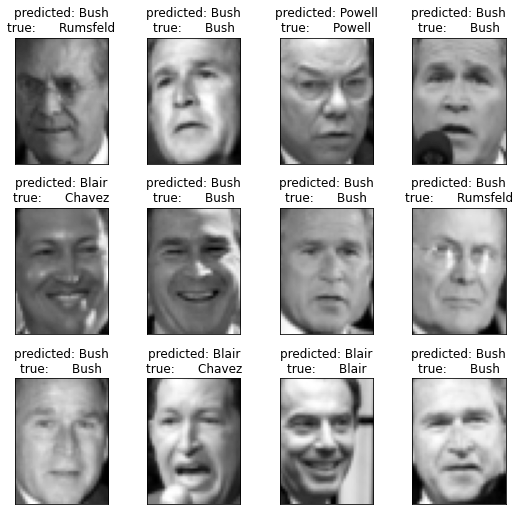

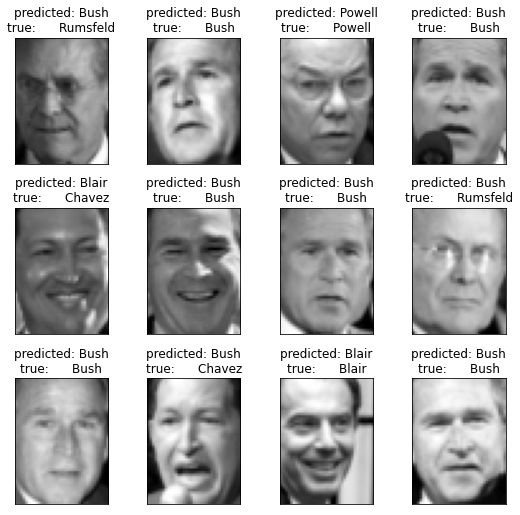

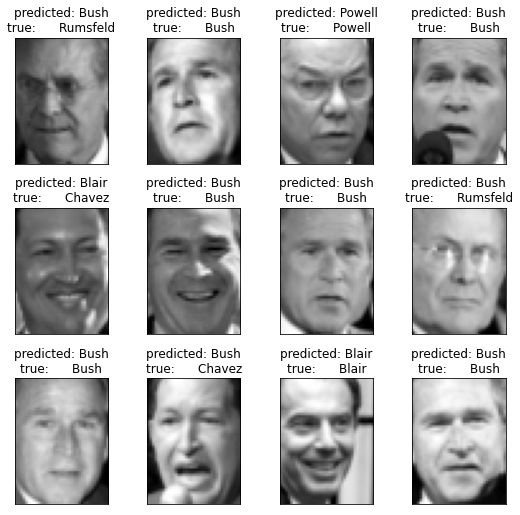

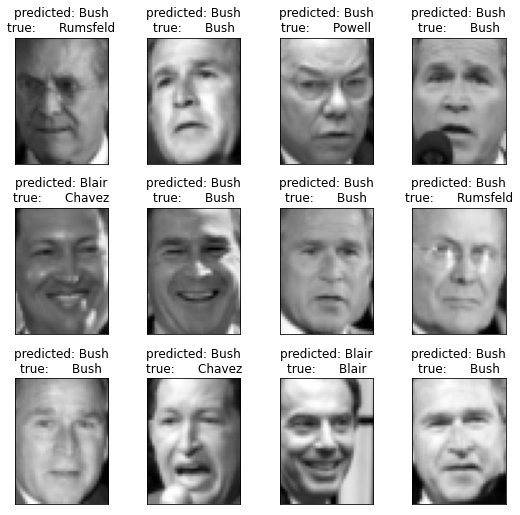

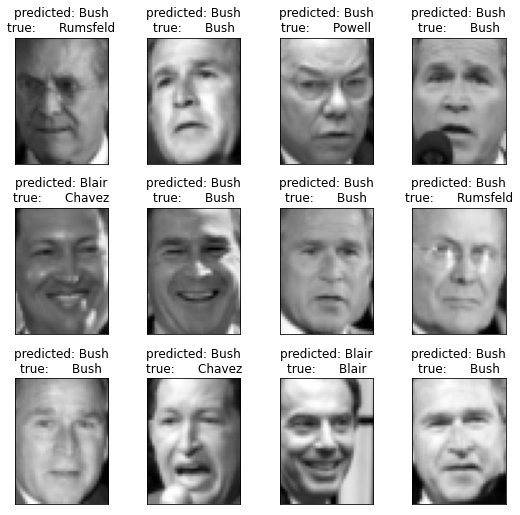

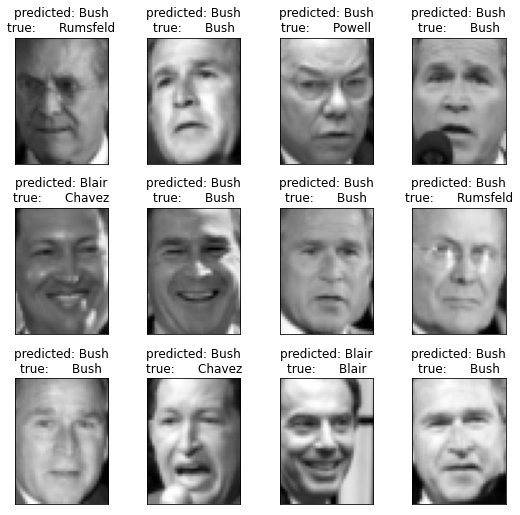

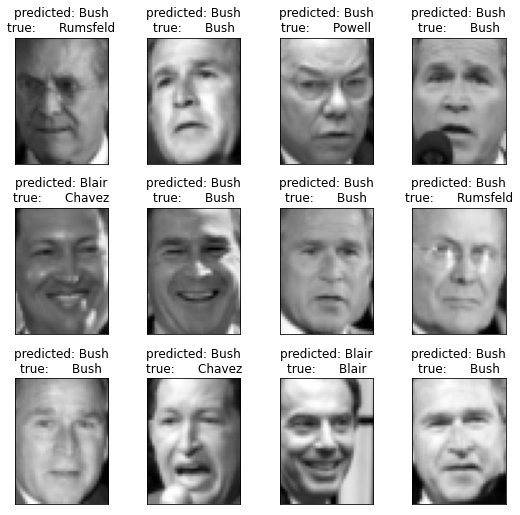

In [30]:
for j in range(len(y_pred)):
  w_prima=np.sqrt(100/(h/w))
  h_prima = 100/w_prima
  print("Número de componentes principales %d "
      % (Q[j]))
  prediction_titles = [title(y_pred[j], y_test, target_names, i)
                      for i in range(y_pred[j].shape[0])]

  plot_gallery(X_test, prediction_titles, h, w)


Se encuentran los parámetros para el regresor logístico

In [44]:
tol = []
C = []

regresion_params = []

for i in range(len(Q)*ksplits):
  clf = train(cross_arr_pca[i][0],cross_arr_pca[i][2],ksplits, 'RL')

  tol.append(clf.best_params_['tol'])
  C.append(clf.best_params_['C'])

  if len(tol)==5:
    tol_sel,c = sp.stats.mode(np.vstack(tol),axis=0)
    C_sel,c = sp.stats.mode(np.vstack(C),axis=0)
    regresion_params.append((C_sel[0][0],tol_sel[0][0]))

    tol = []
    C = []


Se entrena el clasificador y se realiza el test

In [45]:
y_pred = []
for i in range(len(pca_train)): 
  # Se crea el modelo (ej. clasificador)
  clf = LogisticRegression(solver='lbfgs', C=regresion_params[i][0], tol=regresion_params[i][1], max_iter=4000)

  # Se entrena el modelo
  clf.fit(pca_train[i],y_train)

  y_pred.append(clf.predict(pca_test[i]))

Visualización de los rostros

Número de componentes principales 100 
Número de componentes principales 200 
Número de componentes principales 300 
Número de componentes principales 400 
Número de componentes principales 500 
Número de componentes principales 600 
Número de componentes principales 700 


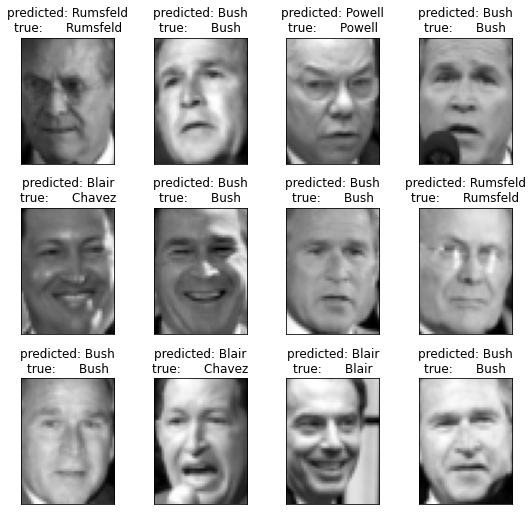

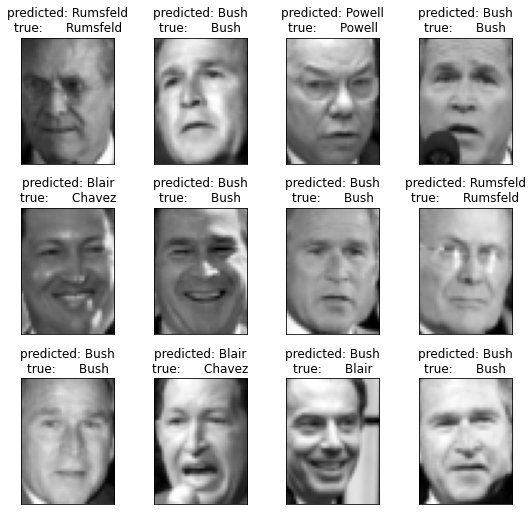

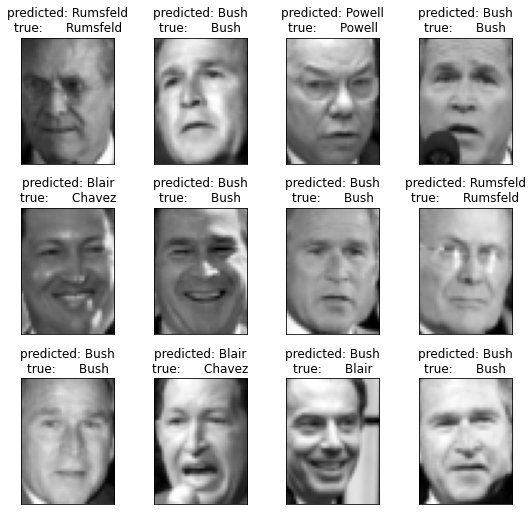

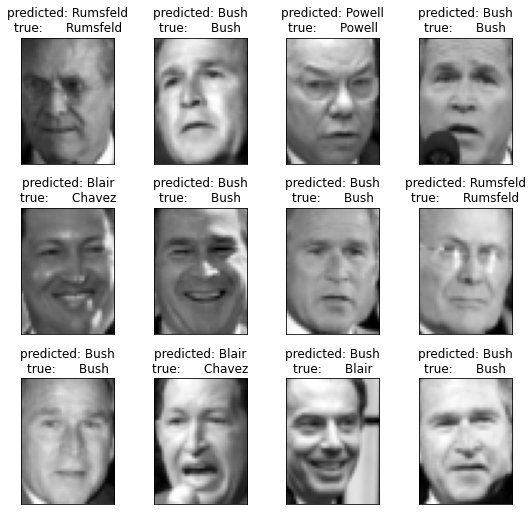

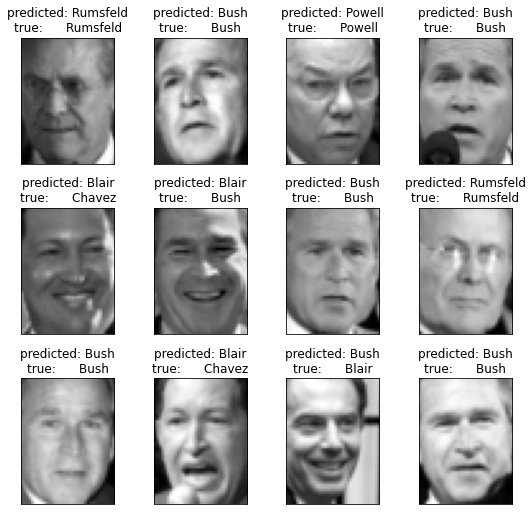

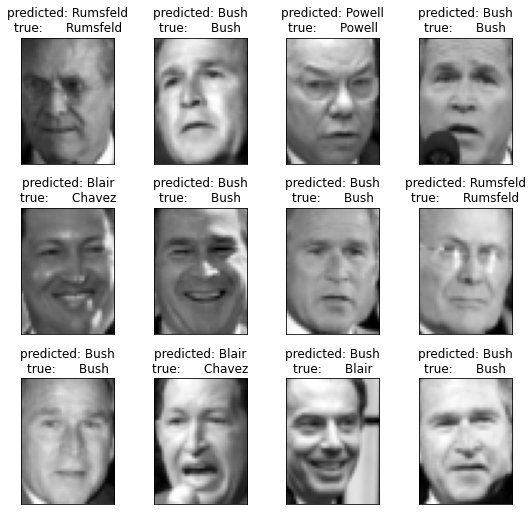

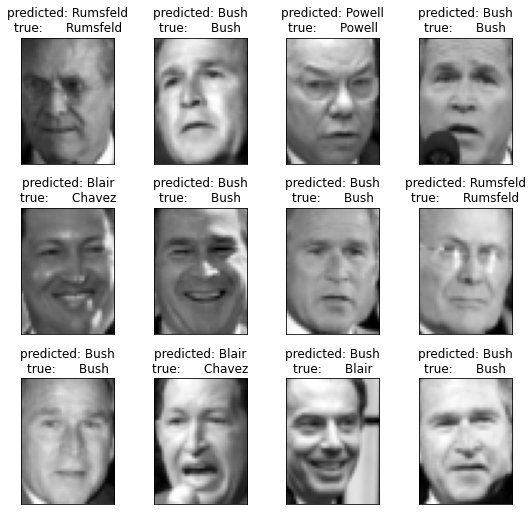

In [46]:
for j in range(len(y_pred)):
  print("Número de componentes principales %d "
      % (Q[j]))
  prediction_titles = [title(y_pred[j], y_test, target_names, i)
                      for i in range(y_pred[j].shape[0])]

  plot_gallery(X_test, prediction_titles, h, w)
